## Hand Sign alphabet recognition

In this project we intend to identify the hand sign alphabet using Convolutional Neural Networks (CNN). For this we are using the dataset from kaggle https://www.kaggle.com/datasets/ash2703/handsignimages. This dataset contains around a 1000 images for each letter (class) in the alphabet for training and around 300-400 for the testing. Since "J" and "Z" in the sign-language alphabet requires movements, this will be omitted.

In [35]:
# Necessary Libraries

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Explore dataset

Since we deal with a bunch of data, we call each image or file when training without need to save all in one variable. Lets first see how the images look like

In [36]:
import os
import random
from pathlib import Path
from PIL import Image

# Train path
Train_path = Path("data/Hand-Sign/Train/")
Test_path = Path("data/Hand-Sign/Test/")

# Get all the train paths
Train_path_list = list(Train_path.glob("*/*.jpg"))
Test_path_list = list(Test_path.glob("*/*.jpg"))

# Randomly pick one from the train
random_image_path = random.choice(Train_path_list)

# Class (letter) of the image
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Random image path: data\Hand-Sign\Train\D\18811_D.jpg
Image class: D
Image height: 28
Image width: 28


this seems a little bit small, lets use matplotlib to increase the image size. Lets plot 9 of this at the same time to look how many of them look like.

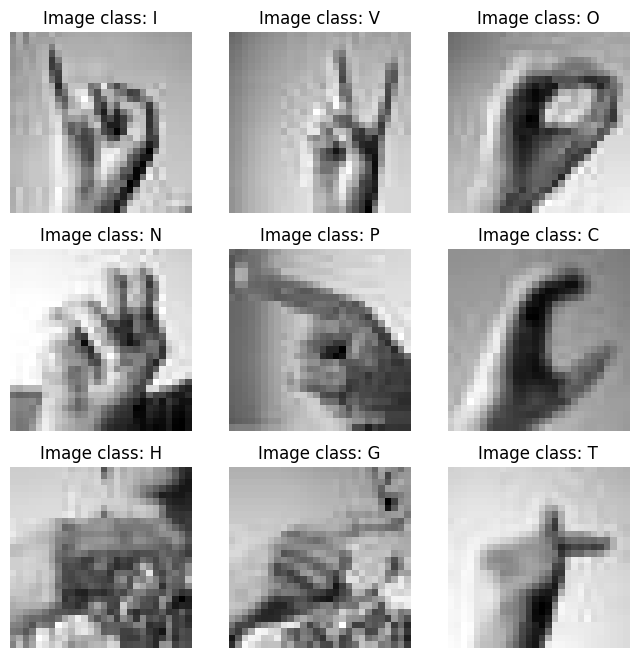

In [37]:
import numpy as np
import matplotlib.pyplot as plt

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize = (8,8))

for ii in range(rows):
    for jj in range(cols):
        # Randomly pick one
        random_image_path = random.choice(Train_path_list)

        # Class (letter) of the image
        image_class = random_image_path.parent.stem

        # Open image
        img = Image.open(random_image_path)
        
        # Convert to numpy array
        img_array = np.asarray(img)

        axes[ii, jj].imshow(img_array, cmap = "grey")
        axes[ii,jj].set_title(f"Image class: {image_class}")
        axes[ii,jj].axis(False)

## Transforming the data
The transformations performed in this dataset will be:
* Image size (28x28) to ensure all images are correct
* Dtype -> uint8
* Random Perspective
* Random rotation
This will allow for better comprehension of the dataset and prevent overfitting.

In [89]:
from torchvision.transforms import v2
data_train_transform = v2.Compose([
    v2.Resize(size = (28, 28)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Grayscale()
])

data_test_transform = v2.Compose([
    v2.Resize(size = (28, 28)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Grayscale()
])

## Setup the datasets

We will use torch built-in function for this and apply the transformations mentioned before

In [90]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root = 'data/Hand-Sign/Train', transform = data_train_transform)
test_dataset = datasets.ImageFolder(root = 'data/Hand-Sign/Test', transform = data_test_transform)

## Create validation split

In [117]:
from torch.utils.data import random_split
val_size = int(0.2*len(test_dataset)) # Take 20% of the test dataset as validation dataset
test_size = len(test_dataset)-val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

## Data Loader
This will split the data in batches preventing from consuming the RAM and speed up the training

In [118]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False) # We don't need to shuffle since this is only for test
val_dataloader = DataLoader(dataset = val_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False) # We don't need to shuffle since this is only for test

## Define model 

Here we will create our CNN model

In [153]:
# Create a convolutional neural network
class SignLanguageCNN(nn.Module):
  """Model architecture that replicates the
  TinyVGG model from CNN explainer website"""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        #Create a conv layer
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3, #Size of the filter sliding through the image
                  stride = 1, #How many pixels jumps to the next slide
                  padding = 1), #How many pixels can the filter get out of the image
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.MaxPool2d(kernel_size = 2) # Takes the max value of the kernel with the image
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.MaxPool2d(kernel_size = 2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*49, #There's a trick to calculating this
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

model0 = SignLanguageCNN(1, 5, 24).to(device)

## Define Loss function and optimizer
We will use adam since it is considered the default best option (not always) and cross entropy loss since we deal with classification

In [154]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0.parameters(), lr = 0.01)

## Train the model

In [155]:
from tqdm import tqdm
num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf') # We will keep track on the best value of loss

for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        model0.train()

        #Forward propagation
        y_pred = model0(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model0.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how test is evolving
    model0.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model0(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    if val_loss < best_val_loss:
       best_val_loss = val_loss
       torch.save(model0.state_dict(), 'best_model0.pth')
       print(f'Saving model with validation loss: {val_loss}')    
       counter = 0
    else:
        counter += 1
    
    if counter == stop_counter:
        break

  1%|          | 1/100 [03:17<5:25:13, 197.11s/it]

Epoch 1 | Train Loss: 0.4800578800353248 | Val Loss: 1.1108239963650703 | Val Acc: 82.21447253705318%
Saving model with validation loss: 1.1108239963650703


  2%|▏         | 2/100 [03:43<2:37:47, 96.61s/it] 

Epoch 2 | Train Loss: 0.07739078142443259 | Val Loss: 1.430896979653173 | Val Acc: 78.37837837837837%


  3%|▎         | 3/100 [04:09<1:44:18, 64.52s/it]

Epoch 3 | Train Loss: 0.05474449039344024 | Val Loss: 1.4764102022680972 | Val Acc: 82.99912816041848%


  4%|▍         | 4/100 [04:36<1:19:10, 49.49s/it]

Epoch 4 | Train Loss: 0.06608031158435039 | Val Loss: 1.4657932346065838 | Val Acc: 86.22493461203139%


  5%|▌         | 5/100 [05:02<1:05:24, 41.31s/it]

Epoch 5 | Train Loss: 0.00035707399006971546 | Val Loss: 1.3313153330236673 | Val Acc: 87.70706190061028%


  6%|▌         | 6/100 [05:34<59:30, 37.98s/it]  

Epoch 6 | Train Loss: 1.570614123212708e-05 | Val Loss: 1.3280221263153686 | Val Acc: 87.53269398430689%


  7%|▋         | 7/100 [06:03<54:28, 35.15s/it]

Epoch 7 | Train Loss: 8.069384911741518e-06 | Val Loss: 1.3610463223109643 | Val Acc: 87.61987794245859%


  8%|▊         | 8/100 [06:33<51:23, 33.51s/it]

Epoch 8 | Train Loss: 5.249082595808692e-06 | Val Loss: 1.3921518065035343 | Val Acc: 87.53269398430689%


  9%|▉         | 9/100 [07:01<47:52, 31.57s/it]

Epoch 9 | Train Loss: 3.4891909698603662e-06 | Val Loss: 1.4245609438253775 | Val Acc: 87.61987794245859%


 10%|█         | 10/100 [07:29<46:03, 30.70s/it]

Epoch 10 | Train Loss: 2.3886744908962046e-06 | Val Loss: 1.459248351967997 | Val Acc: 87.79424585876198%


 10%|█         | 10/100 [07:56<1:11:28, 47.65s/it]

Epoch 11 | Train Loss: 1.6306910725895361e-06 | Val Loss: 1.491663422435522 | Val Acc: 87.70706190061028%


## Model_1 (add more hidden layers)

In [142]:
model1 = SignLanguageCNN(1, 12, 24).to(device)

# Optimizer and Lossfunction

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.01)

# Train

num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf')
for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        model1.train()

        #Forward propagation
        y_pred = model1(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model1.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how test is evolving
    model1.eval()
    correct = 0
    total = 0

    val = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model1(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model1.state_dict(), 'best_model1.pth')
        print(f'Saving model with validation loss: {val_loss}')    
        counter = 0
    else:
        counter += 1

    if counter == stop_counter:
        break

  1%|          | 1/100 [00:26<44:17, 26.84s/it]

Epoch 1 | Train Loss: 0.9005837819775557 | Val Loss: 72.83348913798915 | Val Acc: 83.34786399302529%
Saving model with validation loss: 72.83348913798915


  2%|▏         | 2/100 [00:53<44:00, 26.94s/it]

Epoch 2 | Train Loss: 0.0315536221609949 | Val Loss: 4.157058335512376 | Val Acc: 84.30688753269398%
Saving model with validation loss: 4.157058335512376


  3%|▎         | 3/100 [01:21<43:42, 27.04s/it]

Epoch 3 | Train Loss: 0.03774771609627714 | Val Loss: 2.1477686724544025 | Val Acc: 84.91717523975589%
Saving model with validation loss: 2.1477686724544025


  4%|▍         | 4/100 [01:47<43:11, 27.00s/it]

Epoch 4 | Train Loss: 7.015202269514384 | Val Loss: 42.327343364243376 | Val Acc: 88.66608544027899%


  5%|▌         | 5/100 [02:14<42:34, 26.89s/it]

Epoch 5 | Train Loss: 0.15499142672851668 | Val Loss: 43.4285741702187 | Val Acc: 87.61987794245859%


  6%|▌         | 6/100 [02:41<42:09, 26.91s/it]

Epoch 6 | Train Loss: 0.6817350363798946 | Val Loss: 59.15563465725346 | Val Acc: 81.16826503923278%


  7%|▋         | 7/100 [03:08<41:35, 26.84s/it]

Epoch 7 | Train Loss: 0.9247354520444506 | Val Loss: 46.28273547401333 | Val Acc: 86.66085440278988%


  8%|▊         | 8/100 [03:35<41:34, 27.12s/it]

Epoch 8 | Train Loss: 0.4658122077069234 | Val Loss: 53.29419625487325 | Val Acc: 84.21970357454228%


  9%|▉         | 9/100 [06:31<1:51:15, 73.35s/it]

Epoch 9 | Train Loss: 3.685463524275895 | Val Loss: 91.08496102047363 | Val Acc: 86.74803836094159%


 10%|█         | 10/100 [07:19<1:38:27, 65.63s/it]

Epoch 10 | Train Loss: 0.6160303458007047 | Val Loss: 153.43712171149264 | Val Acc: 83.78378378378379%


 11%|█         | 11/100 [07:48<1:20:57, 54.58s/it]

Epoch 11 | Train Loss: 4.5777385589770425 | Val Loss: 240.3220729651915 | Val Acc: 84.30688753269398%


 12%|█▏        | 12/100 [08:18<1:09:00, 47.05s/it]

Epoch 12 | Train Loss: 2.2209325079107294 | Val Loss: 197.5579456748313 | Val Acc: 86.57367044463818%


 12%|█▏        | 12/100 [08:45<1:04:14, 43.80s/it]

Epoch 13 | Train Loss: 6.839337255164632 | Val Loss: 718.5407314418139 | Val Acc: 82.21447253705318%


## Add image augmentation

We will add a random perspective to train dataset

In [143]:
data_train_transform_aug = v2.Compose([
    v2.Resize(size = (28, 28)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.RandomPerspective(distortion_scale = 0.3, p = 0.2),
    v2.Grayscale()
])

New dataloaders

In [144]:
train_dataset_aug = datasets.ImageFolder(root = 'data/Hand-Sign/Train', transform = data_train_transform_aug)
train_dataloader_aug = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True)

## Model 2 (Model 0 with augmented images)

In [145]:
model2 = SignLanguageCNN(1, 5, 24).to(device)   

# Optimizer and Lossfunction

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.01)

# Train

num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf') # We will keep track on the best value of loss

for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader_aug:
        model2.train()

        #Forward propagation
        y_pred = model2(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model2.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how test is evolving
    model2.eval()
    correct = 0
    total = 0

    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model2(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train_Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), 'best_model2.pth')
        print(f'Saving model with validation loss: {val_loss}')   
        counter = 0
    else:
        counter += 1

    if counter == stop_counter:
        break

  1%|          | 1/100 [00:24<40:49, 24.74s/it]

Epoch 1 | Train_Loss: 0.46707564597686974 | Val Loss: 0.8761316868993971 | Val Acc: 85.00435919790759%
Saving model with validation loss: 0.8761316868993971


  2%|▏         | 2/100 [00:49<40:42, 24.92s/it]

Epoch 2 | Train_Loss: 0.0724338924056199 | Val Loss: 1.1301967030805018 | Val Acc: 84.56843940714909%


  3%|▎         | 3/100 [01:14<39:54, 24.68s/it]

Epoch 3 | Train_Loss: 0.06169379256406241 | Val Loss: 1.4383296403619978 | Val Acc: 84.39407149084569%


  4%|▍         | 4/100 [01:38<39:22, 24.61s/it]

Epoch 4 | Train_Loss: 0.08435161626195047 | Val Loss: 1.8909258287813928 | Val Acc: 86.48648648648648%


  5%|▌         | 5/100 [02:05<40:10, 25.38s/it]

Epoch 5 | Train_Loss: 0.11628072588056758 | Val Loss: 1.9075166899193492 | Val Acc: 86.05056669572798%


  6%|▌         | 6/100 [02:33<41:26, 26.45s/it]

Epoch 6 | Train_Loss: 0.05804754991209404 | Val Loss: 2.5320769677507795 | Val Acc: 85.61464690496949%


  7%|▋         | 7/100 [03:04<43:13, 27.88s/it]

Epoch 7 | Train_Loss: 0.0855553803835692 | Val Loss: 2.3759170739601054 | Val Acc: 87.8814298169137%


  8%|▊         | 8/100 [03:32<42:54, 27.99s/it]

Epoch 8 | Train_Loss: 0.04863663291408216 | Val Loss: 4.644630481385523 | Val Acc: 83.17349607672189%


  9%|▉         | 9/100 [04:01<42:39, 28.12s/it]

Epoch 9 | Train_Loss: 0.12533609911772925 | Val Loss: 4.492503314266084 | Val Acc: 84.74280732345248%


 10%|█         | 10/100 [04:29<42:07, 28.08s/it]

Epoch 10 | Train_Loss: 0.09303119834557827 | Val Loss: 4.192103352811602 | Val Acc: 88.84045335658239%


 10%|█         | 10/100 [04:57<44:41, 29.79s/it]

Epoch 11 | Train_Loss: 0.12519658048082166 | Val Loss: 6.388332794109981 | Val Acc: 86.74803836094159%


## Model 3 (Model 1 with augmented images)

In [146]:
model3 = SignLanguageCNN(1, 12, 24).to(device)   

# Optimizer and Lossfunction

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr = 0.01)

# Train

num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf') # We will keep track on the best value of loss

for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader_aug:
        model3.train()

        #Forward propagation
        y_pred = model3(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model3.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how test is evolving
    model3.eval()
    correct = 0
    total = 0

    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model3(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train_Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model3.state_dict(), 'best_model3.pth')
        print(f'Saving model with validation loss: {val_loss}')  
        counter = 0
    else:
        counter += 1

    if counter == stop_counter:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:32<53:33, 32.46s/it]

Epoch 1 | Train_Loss: 2.468302570739237 | Val Loss: 27.300830708609688 | Val Acc: 71.83958151700087%
Saving model with validation loss: 27.300830708609688


  2%|▏         | 2/100 [01:02<50:28, 30.90s/it]

Epoch 2 | Train_Loss: 0.3544575855793738 | Val Loss: 10.038758001804316 | Val Acc: 89.62510897994768%
Saving model with validation loss: 10.038758001804316


  3%|▎         | 3/100 [01:30<48:07, 29.77s/it]

Epoch 3 | Train_Loss: 0.0793132012986618 | Val Loss: 11.57105827331543 | Val Acc: 84.39407149084569%


  4%|▍         | 4/100 [02:00<47:26, 29.65s/it]

Epoch 4 | Train_Loss: 0.1266514017771793 | Val Loss: 11.85733781589402 | Val Acc: 83.78378378378379%


  5%|▌         | 5/100 [02:31<47:51, 30.23s/it]

Epoch 5 | Train_Loss: 0.2791604068016304 | Val Loss: 13.798433423042297 | Val Acc: 84.56843940714909%


  6%|▌         | 6/100 [03:03<48:11, 30.76s/it]

Epoch 6 | Train_Loss: 8.23194461068437 | Val Loss: 72.84692522876715 | Val Acc: 88.05579773321709%


  7%|▋         | 7/100 [03:33<47:17, 30.52s/it]

Epoch 7 | Train_Loss: 0.19524183798464934 | Val Loss: 58.2676444444288 | Val Acc: 87.18395815170008%


  8%|▊         | 8/100 [04:02<46:04, 30.05s/it]

Epoch 8 | Train_Loss: 0.17412920611698987 | Val Loss: 85.51926305558946 | Val Acc: 84.82999128160418%


  9%|▉         | 9/100 [04:32<45:39, 30.11s/it]

Epoch 9 | Train_Loss: 0.8556238217263227 | Val Loss: 82.78745391633775 | Val Acc: 86.05056669572798%


 10%|█         | 10/100 [05:03<45:36, 30.40s/it]

Epoch 10 | Train_Loss: 1.183259329006948 | Val Loss: 139.75621244642468 | Val Acc: 82.82476024411508%


 11%|█         | 11/100 [05:34<45:09, 30.44s/it]

Epoch 11 | Train_Loss: 2.4660488486424033 | Val Loss: 141.70946089426675 | Val Acc: 87.35832606800349%


 11%|█         | 11/100 [06:03<49:03, 33.07s/it]

Epoch 12 | Train_Loss: 3.8737347960310804 | Val Loss: 358.1395420498318 | Val Acc: 84.39407149084569%


## Model 4 (Model 0 with regularization)
Dropout 20% of neurons randomly at each layer

In [217]:
# Create a convolutional neural network
class SignLanguageCNN_REG(nn.Module):
  """Model architecture that replicates the
  TinyVGG model from CNN explainer website"""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               dropout_p: float):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        #Create a conv layer
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3, #Size of the filter sliding through the image
                  stride = 1, #How many pixels jumps to the next slide
                  padding = 1), #How many pixels can the filter get out of the image
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.MaxPool2d(kernel_size = 2) # Takes the max value of the kernel with the image
    )
    self.dropout1 = nn.Dropout(p = dropout_p)
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.MaxPool2d(kernel_size = 2))
    self.dropout2 = nn.Dropout(p = dropout_p)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*49, #There's a trick to calculating this
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.dropout1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.dropout2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x

In [148]:
model4 = SignLanguageCNN_REG(1, 5, 24, 0.2).to(device)

# Optimizer and Lossfunction

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr = 0.01)

# Train

num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf') # We will keep track on the best value of loss

for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader_aug:
        model4.train()

        #Forward propagation
        y_pred = model4(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model4.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how test is evolving
    model4.eval()
    correct = 0
    total = 0

    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model4(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train_Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model4.state_dict(), 'best_model4.pth')
        print(f'Saving model with validation loss: {val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == stop_counter:
        break

  1%|          | 1/100 [00:27<45:34, 27.62s/it]

Epoch 1 | Train_Loss: 0.8524301655434229 | Val Loss: 0.6294814666940106 | Val Acc: 82.38884045335658%
Saving model with validation loss: 0.6294814666940106


  2%|▏         | 2/100 [00:58<48:17, 29.56s/it]

Epoch 2 | Train_Loss: 0.2621139851062274 | Val Loss: 0.6652191304084327 | Val Acc: 86.74803836094159%


  3%|▎         | 3/100 [01:26<46:45, 28.92s/it]

Epoch 3 | Train_Loss: 0.22049270545312644 | Val Loss: 0.6301666936940618 | Val Acc: 85.70183086312119%


  4%|▍         | 4/100 [01:54<45:24, 28.38s/it]

Epoch 4 | Train_Loss: 0.2049345188179338 | Val Loss: 0.8120471721308099 | Val Acc: 85.00435919790759%


  5%|▌         | 5/100 [02:22<44:51, 28.33s/it]

Epoch 5 | Train_Loss: 0.2067435877522484 | Val Loss: 0.6278446358111169 | Val Acc: 86.39930252833479%
Saving model with validation loss: 0.6278446358111169


  6%|▌         | 6/100 [02:49<43:39, 27.87s/it]

Epoch 6 | Train_Loss: 0.18077952029630714 | Val Loss: 0.4911651418854793 | Val Acc: 88.66608544027899%
Saving model with validation loss: 0.4911651418854793


  7%|▋         | 7/100 [03:18<43:48, 28.26s/it]

Epoch 7 | Train_Loss: 0.19307100666808463 | Val Loss: 0.502822980698612 | Val Acc: 87.96861377506539%


  8%|▊         | 8/100 [03:45<42:54, 27.99s/it]

Epoch 8 | Train_Loss: 0.17909622423625973 | Val Loss: 0.5350493759744697 | Val Acc: 86.66085440278988%


  9%|▉         | 9/100 [04:11<41:13, 27.18s/it]

Epoch 9 | Train_Loss: 0.18082458106231047 | Val Loss: 0.5298442646033235 | Val Acc: 88.05579773321709%


 10%|█         | 10/100 [04:39<41:18, 27.54s/it]

Epoch 10 | Train_Loss: 0.18192865667562924 | Val Loss: 0.5642933808267117 | Val Acc: 88.14298169136879%


 11%|█         | 11/100 [05:06<40:22, 27.21s/it]

Epoch 11 | Train_Loss: 0.16038816916249696 | Val Loss: 0.6008386763019694 | Val Acc: 87.61987794245859%


 12%|█▏        | 12/100 [05:33<39:59, 27.27s/it]

Epoch 12 | Train_Loss: 0.17425222077187408 | Val Loss: 0.6307094879448414 | Val Acc: 88.14298169136879%


 13%|█▎        | 13/100 [06:00<39:31, 27.26s/it]

Epoch 13 | Train_Loss: 0.16595973234887165 | Val Loss: 0.7556605190038681 | Val Acc: 86.22493461203139%


 14%|█▍        | 14/100 [06:27<38:56, 27.17s/it]

Epoch 14 | Train_Loss: 0.17836092693835937 | Val Loss: 0.554060235619545 | Val Acc: 86.31211857018309%


 15%|█▌        | 15/100 [06:54<38:19, 27.06s/it]

Epoch 15 | Train_Loss: 0.1584741010622402 | Val Loss: 0.5209959606743522 | Val Acc: 88.66608544027899%


 15%|█▌        | 15/100 [07:20<41:37, 29.38s/it]

Epoch 16 | Train_Loss: 0.17093808812300657 | Val Loss: 0.515579610856043 | Val Acc: 89.1891891891892%


## Model 5 (Model 1 with regularization)

In [149]:
model5 = SignLanguageCNN_REG(1, 5, 24, 0.2).to(device)

# Optimizer and Lossfunction

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr = 0.01)

# Train

num_epochs = 100

stop_counter = 10
counter = 0

best_val_loss = float('inf') # We will keep track on the best value of loss

for epoch in tqdm(range(num_epochs)):
    # Set model to training model
    running_loss = 0.0
    for inputs, labels in train_dataloader_aug:
        model5.train()

        #Forward propagation
        y_pred = model5(inputs.to(device))
        
        # Calculate loss
        loss = loss_function(y_pred, labels.to(device))

         # Zero grad
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Check Gradient
        for name, param in model5.named_parameters():
            if param.grad is None:
                print(f'{name} has no gradient')
                
        # Optimize parameters
        optimizer.step()

        running_loss += loss.item()

    # Check how validation is evolving
    model5.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model5(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    loss_test = running_loss/len(train_dataloader)

    print(f'Epoch {epoch+1} | Train_Loss: {loss_test} | Val Loss: {val_loss} | Val Acc: {100*correct/total}%')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model5.state_dict(), 'best_model5.pth')
        print(f'Saving model with validation loss: {val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == stop_counter:
        break

  1%|          | 1/100 [00:27<45:09, 27.37s/it]

Epoch 1 | Train_Loss: 0.6654482052416165 | Val Loss: 0.707384088387092 | Val Acc: 83.78378378378379%
Saving model with validation loss: 0.707384088387092


  2%|▏         | 2/100 [00:55<45:10, 27.66s/it]

Epoch 2 | Train_Loss: 0.2773342593258251 | Val Loss: 0.7695273169212871 | Val Acc: 85.17872711421099%


  3%|▎         | 3/100 [01:22<44:15, 27.38s/it]

Epoch 3 | Train_Loss: 0.2409372446105527 | Val Loss: 0.6647609886195924 | Val Acc: 86.83522231909329%
Saving model with validation loss: 0.6647609886195924


  4%|▍         | 4/100 [01:49<43:24, 27.13s/it]

Epoch 4 | Train_Loss: 0.22759129962298286 | Val Loss: 0.7129698544740677 | Val Acc: 85.44027898866608%


  5%|▌         | 5/100 [02:14<42:12, 26.66s/it]

Epoch 5 | Train_Loss: 0.2064782952628476 | Val Loss: 0.53069857466552 | Val Acc: 86.48648648648648%
Saving model with validation loss: 0.53069857466552


  6%|▌         | 6/100 [02:40<41:25, 26.44s/it]

Epoch 6 | Train_Loss: 0.2024475167801773 | Val Loss: 0.5957278629971875 | Val Acc: 86.48648648648648%


  7%|▋         | 7/100 [03:07<41:18, 26.65s/it]

Epoch 7 | Train_Loss: 0.1917710047651306 | Val Loss: 0.7307097824911276 | Val Acc: 84.21970357454228%


  8%|▊         | 8/100 [03:36<41:48, 27.27s/it]

Epoch 8 | Train_Loss: 0.19802607924542834 | Val Loss: 0.6589174802518554 | Val Acc: 84.82999128160418%


  9%|▉         | 9/100 [04:04<41:29, 27.36s/it]

Epoch 9 | Train_Loss: 0.18980452851560575 | Val Loss: 0.5107506865945955 | Val Acc: 89.36355710549259%
Saving model with validation loss: 0.5107506865945955


 10%|█         | 10/100 [04:31<40:53, 27.26s/it]

Epoch 10 | Train_Loss: 0.18180290673378965 | Val Loss: 0.5429130192432139 | Val Acc: 87.8814298169137%


 11%|█         | 11/100 [04:59<40:45, 27.48s/it]

Epoch 11 | Train_Loss: 0.177198463771248 | Val Loss: 0.6044690753850672 | Val Acc: 88.75326939843069%


 12%|█▏        | 12/100 [05:27<40:31, 27.63s/it]

Epoch 12 | Train_Loss: 0.18460017640480397 | Val Loss: 0.6878504479924837 | Val Acc: 89.62510897994768%


 13%|█▎        | 13/100 [05:54<40:00, 27.59s/it]

Epoch 13 | Train_Loss: 0.1702506845726877 | Val Loss: 0.527990380457292 | Val Acc: 86.22493461203139%


 14%|█▍        | 14/100 [06:21<39:20, 27.45s/it]

Epoch 14 | Train_Loss: 0.18456275144085563 | Val Loss: 0.6029359907325771 | Val Acc: 88.23016564952049%


 15%|█▌        | 15/100 [06:49<39:01, 27.55s/it]

Epoch 15 | Train_Loss: 0.16852713584664358 | Val Loss: 0.6838928833603859 | Val Acc: 88.4917175239756%


 16%|█▌        | 16/100 [07:16<38:17, 27.35s/it]

Epoch 16 | Train_Loss: 0.18213764939547814 | Val Loss: 0.5534435455144072 | Val Acc: 88.57890148212729%


 17%|█▋        | 17/100 [07:43<37:45, 27.29s/it]

Epoch 17 | Train_Loss: 0.18016029673474918 | Val Loss: 0.7365245059546497 | Val Acc: 87.70706190061028%


 18%|█▊        | 18/100 [08:11<37:25, 27.38s/it]

Epoch 18 | Train_Loss: 0.16792184062625579 | Val Loss: 0.6602709119518598 | Val Acc: 87.00959023539669%


 18%|█▊        | 18/100 [08:38<39:20, 28.78s/it]

Epoch 19 | Train_Loss: 0.15977278963354277 | Val Loss: 0.6816004096633859 | Val Acc: 87.44551002615519%


In [150]:
model0.load_state_dict(torch.load('best_model0.pth'))
model1.load_state_dict(torch.load('best_model1.pth'))
model2.load_state_dict(torch.load('best_model2.pth'))
model3.load_state_dict(torch.load('best_model3.pth'))
model4.load_state_dict(torch.load('best_model4.pth'))
model5.load_state_dict(torch.load('best_model5.pth'))

<All keys matched successfully>

In [194]:
models = [model0, model1, model2, model3, model4, model5]
model_accuracy = []
model_loss = []
for model in tqdm(models):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            test_loss += loss_function(outputs, labels.to(device)).item()*labels.size(0)
        model_accuracy.append(100*correct/total)
        model_loss.append(test_loss/total)

models_names = ['model0', 'model1', 'model2', 'model3', 'model4', 'modle5']

100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


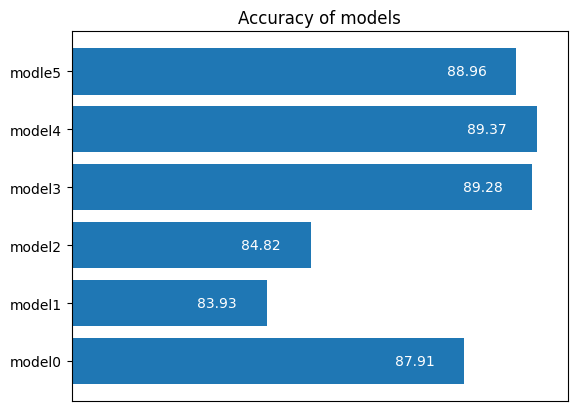

In [196]:
fig, ax = plt.subplots()
bars =  ax.barh(models_names, model_accuracy)

# Add labels to the bars
for bar in bars:
    width = bar.get_width()  # Get the width of the bar (i.e., the value)
    ax.text(width-1, bar.get_y() + bar.get_height() / 2,
            f'{np.round(width, 2)}', ha='center', va='center', c = 'white')
    
ax.set_xlim(80, 90)
ax.set_title('Accuracy of models')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

### Raw Models

In the first two models (no augmentation neither regulation), we see better results from the model0 with 5 units rather than the one with 12 units (model1). This is a signal that with 12 units we are overfitting through the training data.

### Image Augmentation

After applying image augmentation we get the opposite results, i.e., the model3 with 12 neurons performs much better than the model 2 with 5 neurons. The image augmentation allowed model3 to avoid overfitting and get a better generalization of the problem. Then the model2 wasn't capable learning good enough about the training data, slightly underfitting.

### Dropout

Then we created models 4 (5 hidden units) and 5 (12 hidden units) which had dropout regulation to allow for even a better generalization. This showed an improvement in model4 whith a slightly better result than model3 with just image augmentation. But the model5 got worst results. 

### Overall

From all, we see better results in the model4 with image augmentation and dropout of 20%. Nevertheless model3 still has a high accuracy. To get a better idea of the certainty in each model we take into account the average loss. Lets remember that a low loss indicates a better certainty over the decisions and high loss a worst certainty.

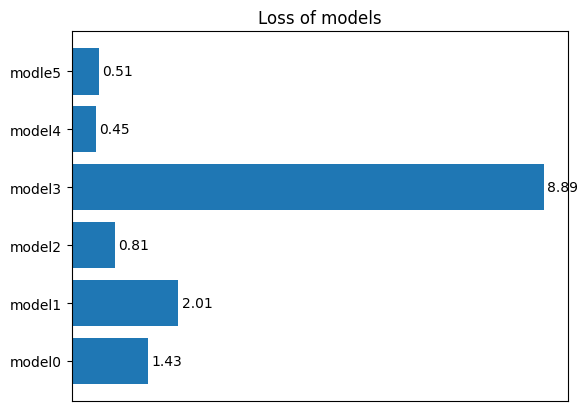

In [197]:
fig, ax = plt.subplots()
bars =  ax.barh(models_names, model_loss)

# Add labels to the bars
for bar in bars:
    width = bar.get_width()  # Get the width of the bar (i.e., the value)
    ax.text(width+0.35, bar.get_y() + bar.get_height() / 2,
            f'{np.round(width, 2)}', ha='center', va='center')
    
ax.set_title('Loss of models')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

Comparing the 2 main models (model3 and model4), we findout that model4 is not just more certain than model3 but has the best certainty over all models. The other way around, model3 has the worst certainty from all. Actually the loss is even higher than a random guessing (i.e. Log(24) = 3.18), this suggests that the model3 is overconfident on the wrong guesses increasing the loss by a lot, and probably not so certain with correct predictions. From this we can tell that the best model is model4, since it has a low loss and high accuracy. Another advantage is that this model needs less memory space than the one with 12 hidden units.

## Watch for predictions

In [253]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 
           'H', 'I', 'K', 'L', 'M', 'N', 'O', 
           'P', 'Q', 'R', 'S', 'T', 'U', 'V',
           'W', 'X', 'Y']

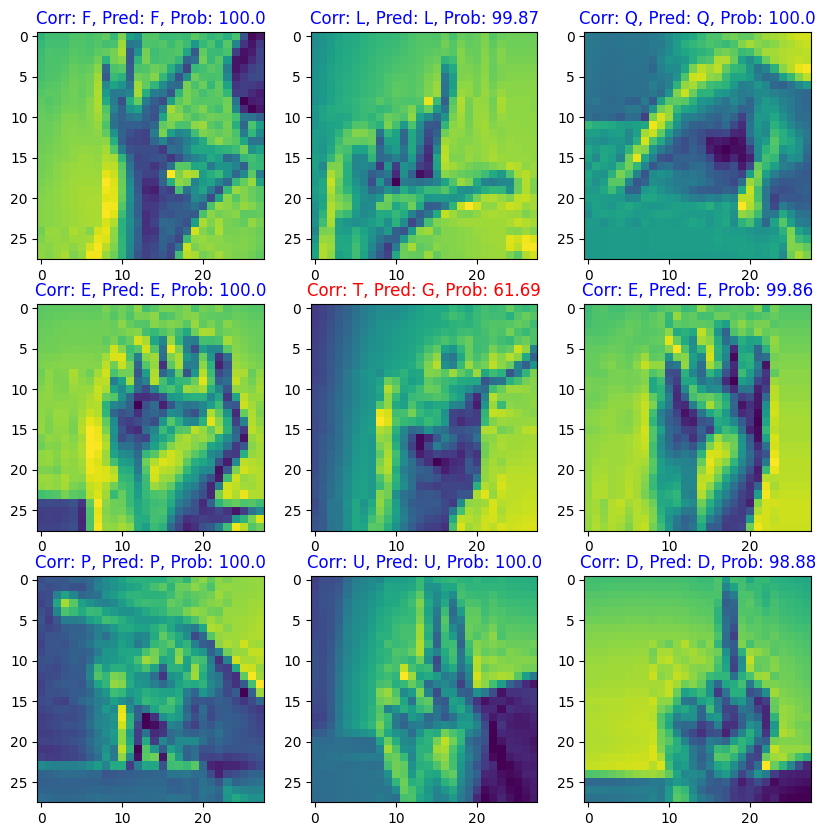

In [265]:
model4.eval()
pos = np.random.randint(0, len(test_dataset)-1, 9)

fig, ax = plt.subplots(3, 3, figsize = (10, 10))

with torch.no_grad():
    for ii in range(3):
        for jj in range(3):
            inputs, label = test_dataset[pos[3*ii + jj]]
            inputs = torch.unsqueeze(inputs, dim = 0).to(device)
            output = model4(inputs)
            guess = torch.argmax(output).item()
            probability = torch.max(torch.softmax(output, dim = 1)).item()
            
            color = 'blue'
            if guess != label:
                color = 'red'
            ax[ii, jj].imshow(torch.squeeze(inputs).cpu())
            ax[ii, jj].set_title(f'Corr: {letters[label]}, Pred: {letters[guess]}, Prob: {np.round(100*probability, 2)}', color = color)

Finally we can see that the wrong predictions are with confusable data, for example letter 'h' and 'g' are quite similar so it is not unusual to get confused (even I thought it was g in some examples shown). 